In [18]:
%autosave 1

Autosaving every 1 seconds


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import pathlib
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy
from sklearn.metrics import confusion_matrix
import itertools

In [8]:
data_dir = r'E:\Surya MS6\split dataset'
data_dir = pathlib.Path(data_dir)
train_dir = r'E:\Surya MS6\split dataset\train'
train_dir = pathlib.Path(train_dir)
test_dir = r'E:\Surya MS6\split dataset\test'
test_dir = pathlib.Path(test_dir)
valid_dir = r'E:\Surya MS6\split dataset\val'
valid_dir = pathlib.Path(valid_dir)

In [9]:
batch_size = 16
img_height = 224
img_width = 224

In [10]:
print(tf.__version__)

2.8.0


In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 6101 files belonging to 2 classes.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 1743 files belonging to 2 classes.


In [13]:
test_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode = "categorical",
    seed=123,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=1, shuffle = False)

Found 872 files belonging to 2 classes.


In [14]:
class_names = test_ds.class_names
print(class_names)

['Healthy', 'Sick']


In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16, 2)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

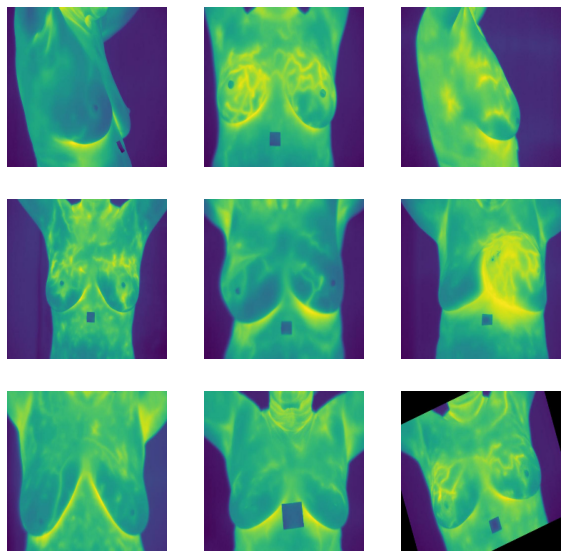

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    #pooling="max",
    #classifier_activation="softmax",
)

58900480/58889256 [==============================] - 6s 0us/step


In [20]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 512)


In [21]:
base_model.trainable = False

In [22]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
prediction_layer = tf.keras.layers.Dense(2,activation=tf.keras.activations.softmax)

In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(inputs, training=False)
# x = global_average_layer(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
filepath = r'E:\Surya MS6\Models\VGG16\VGG16.h5'

In [27]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_binary_accuracy", 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=False
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=1e-3,
    min_lr = 5*1e-12,
    )

callbacks = [model_save,  reduce_lr]#, early_stop,]

In [28]:
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='binary_accuracy')

In [29]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=StepsPerEpoch, 
    epochs = 20,
    callbacks= callbacks, 
    #validation_steps=ValidationSteps, 
    use_multiprocessing= True
    )

Epoch 1/20
382/382 [==============================] - 118s 305ms/step - loss: 0.8767 - binary_accuracy: 0.6332 - val_loss: 0.6239 - val_binary_accuracy: 0.7229 - lr: 1.0000e-04
Epoch 2/20
382/382 [==============================] - 113s 296ms/step - loss: 0.5524 - binary_accuracy: 0.7441 - val_loss: 0.4979 - val_binary_accuracy: 0.7671 - lr: 1.0000e-04
Epoch 3/20
382/382 [==============================] - 116s 303ms/step - loss: 0.4545 - binary_accuracy: 0.7854 - val_loss: 0.4213 - val_binary_accuracy: 0.8090 - lr: 1.0000e-04
Epoch 4/20
382/382 [==============================] - 115s 302ms/step - loss: 0.3915 - binary_accuracy: 0.8200 - val_loss: 0.3691 - val_binary_accuracy: 0.8365 - lr: 1.0000e-04
Epoch 5/20
382/382 [==============================] - 115s 302ms/step - loss: 0.3476 - binary_accuracy: 0.8431 - val_loss: 0.3315 - val_binary_accuracy: 0.8548 - lr: 1.0000e-04
Epoch 6/20
382/382 [==============================] - 115s 302ms/step - loss: 0.3153 - binary_accuracy: 0.8608 - va

In [37]:
export_dir=r'E:\Surya MS6\Models\VGG16\VGG16_save_model\\'
model.save(export_dir)

INFO:tensorflow:Assets written to: E:\Surya MS6\Models\VGG16\VGG16_save_model\\assets


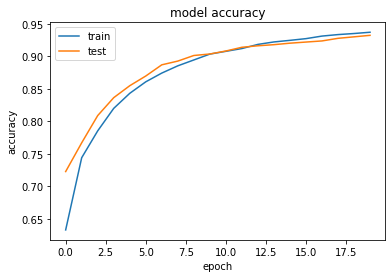

In [30]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



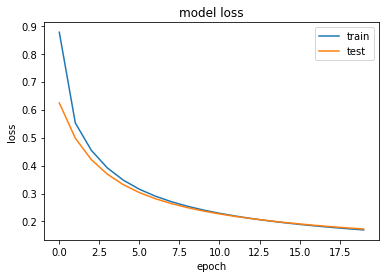

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()



In [32]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)



872/872 [==============================] - 26s 28ms/step


In [33]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]




0

In [34]:
conf_mat = confusion_matrix(rounded_labels, y_pred)

classes = class_names


classes

['Healthy', 'Sick']

In [36]:
conf_mat

array([[418,  32],
       [ 22, 400]], dtype=int64)

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



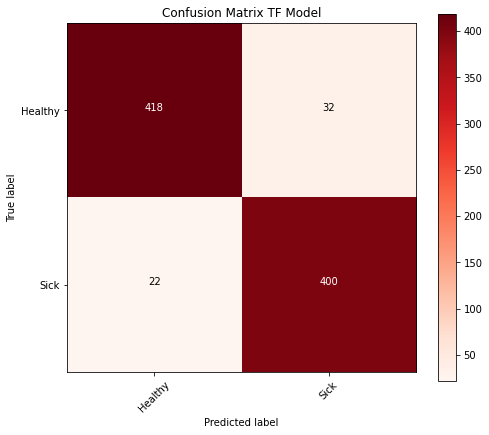

In [38]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig(r'E:\Surya MS6\Models\VGG16\cm_wo_norm_1.png')
plt.show()



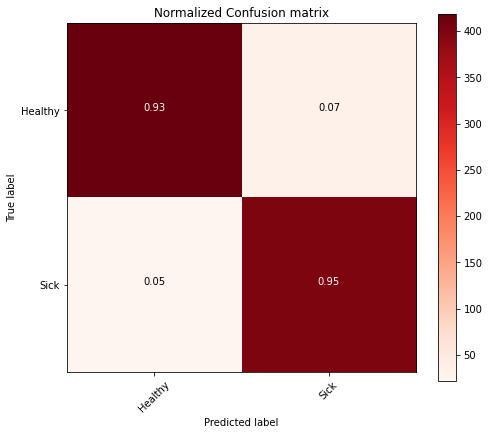

In [39]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig(r'E:\Surya MS6\Models\VGG16\cm_norm_1.png')
plt.show()



In [40]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.95      0.93      0.94       450
        Sick       0.93      0.95      0.94       422

    accuracy                           0.94       872
   macro avg       0.94      0.94      0.94       872
weighted avg       0.94      0.94      0.94       872



# Fine-Tuning

In [41]:
filepath = r'E:\Surya MS6\Models\VGG16\VGG16_fine_tuned.h5'

In [42]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_binary_accuracy", 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=False
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=1e-3,
    min_lr = 5*1e-12,
    )

callbacks = [model_save,  reduce_lr, early_stop,]

In [43]:
base_model.trainable = True
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='binary_accuracy')

In [44]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=StepsPerEpoch, 
    epochs = 20,
    callbacks= callbacks, 
    #validation_steps=ValidationSteps, 
    use_multiprocessing= True
    )

Epoch 1/20
382/382 [==============================] - 284s 717ms/step - loss: 0.4515 - binary_accuracy: 0.7889 - val_loss: 0.2767 - val_binary_accuracy: 0.8514 - lr: 1.0000e-04
Epoch 2/20
382/382 [==============================] - 283s 742ms/step - loss: 0.2226 - binary_accuracy: 0.9035 - val_loss: 0.1550 - val_binary_accuracy: 0.9392 - lr: 1.0000e-04
Epoch 3/20
382/382 [==============================] - 284s 742ms/step - loss: 0.1365 - binary_accuracy: 0.9462 - val_loss: 0.1085 - val_binary_accuracy: 0.9616 - lr: 1.0000e-04
Epoch 4/20
382/382 [==============================] - 284s 745ms/step - loss: 0.0986 - binary_accuracy: 0.9620 - val_loss: 0.0924 - val_binary_accuracy: 0.9662 - lr: 1.0000e-04
Epoch 5/20
382/382 [==============================] - 268s 702ms/step - loss: 0.0899 - binary_accuracy: 0.9656 - val_loss: 0.0790 - val_binary_accuracy: 0.9662 - lr: 1.0000e-04
Epoch 6/20
382/382 [==============================] - 278s 728ms/step - loss: 0.3991 - binary_accuracy: 0.8025 - va

In [45]:
export_dir=r'E:\Surya MS6\Models\VGG16\VGG16_save_model_finetuned\\'
model.save(export_dir)

INFO:tensorflow:Assets written to: E:\Surya MS6\Models\VGG16\VGG16_save_model_finetuned\\assets


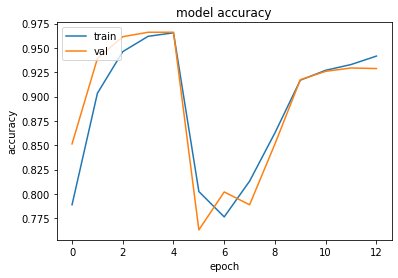

In [46]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



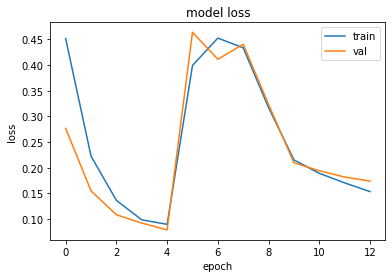

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()



In [48]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)



872/872 [==============================] - 25s 28ms/step


In [49]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]




0

In [50]:
conf_mat = confusion_matrix(rounded_labels, y_pred)

classes = class_names


conf_mat

array([[444,   6],
       [ 46, 376]], dtype=int64)

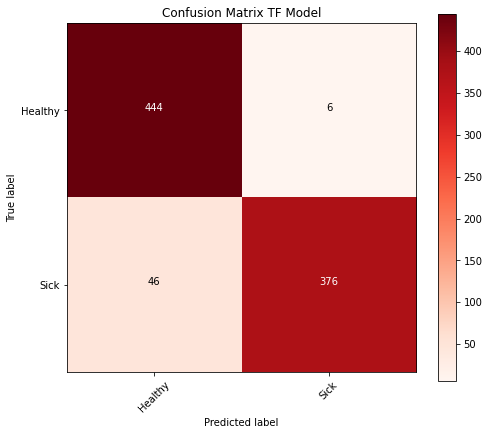

In [51]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig(r'E:\Surya MS6\Models\VGG16\cm_wo_norm.png')
plt.show()



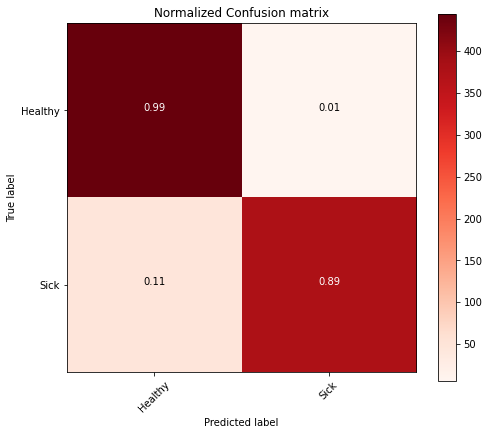

In [52]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig(r'E:\Surya MS6\Models\VGG16\cm_norm.jpg')
plt.show()



In [53]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.91      0.99      0.94       450
        Sick       0.98      0.89      0.94       422

    accuracy                           0.94       872
   macro avg       0.95      0.94      0.94       872
weighted avg       0.94      0.94      0.94       872



In [ ]:
import tensorflow as tf

model_save = tf.keras.models.load_model('/content/drive/MyDrive/Minor Sem 6/Classification with augmentation/EfficientNetB7_withfine_tuning/EfficientNetB7_fine.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_save)
tflite_model = converter.convert()
open("efficientNetb7_fine_tuned.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0h2ajenx/assets


254857188

In [ ]:
add = '/content/drive/MyDrive/Minor Sem 6/Classification with augmentation/EfficientNetB7_withfine_tuning/tflite_model/efficientNetb7_fine_tuned.tflite'
open(add, "wb").write(tflite_model)

254857188

In [ ]:
%ls

cm_norm.jpg     drive/                            sample_data/
cm_wo_norm.png  efficientNetb7_fine_tuned.tflite


In [ ]:
!cp efficientNetb7_fine_tuned.tflite 